In [97]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import SGD

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set(style='whitegrid')

### Basic Lightning module
same as `torch` except we use `L.LightningModule` instead 

In [98]:
class BasicLightning(L.LightningModule) : 
    def __init__(self) : 
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=False)

    def forward(self, input) :
        input_to_top_relu = input*self.w00 + self.b00 
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output*self.w01

        input_to_bottom_relu = input*self.w10 + self.b10 
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output*self.w11 

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)
        return output 

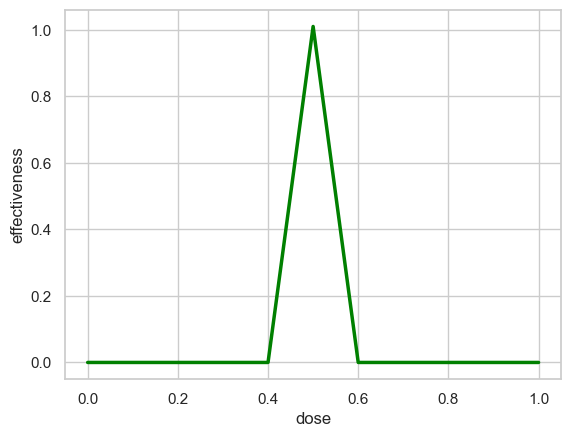

In [99]:
input_doses = torch.linspace(start=0, end = 1, steps = 11)
model = BasicLightning()
output_values = model(input_doses)
sns.lineplot(
    x = input_doses, y = output_values, 
    color = 'green', linewidth = 2.5
)
plt.ylabel('effectiveness')
plt.xlabel('dose');

### Lightning Train

In [100]:
class BasicLightning_train(L.LightningModule) : 
    def __init__(self) : 
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(0.), requires_grad=True)
        self.learning_rate = 0.01

    def forward(self, input) :
        input_to_top_relu = input*self.w00 + self.b00 
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output*self.w01

        input_to_bottom_relu = input*self.w10 + self.b10 
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output*self.w11 

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)
        return output 
    
    def configure_optimizers(self) :
        return SGD(self.parameters(), lr = self.learning_rate)
    
    def training_step(self, batch, batch_idx) :
        input_i, label_i = batch 
        output_i = self.forward(input_i)
        loss = (output_i - label_i)**2  
        return loss

* `DataLoader` makes it easy to access the data in batches. 
* makes it easy to shuffle the data each epoch. 
* makes it easy to use a relatively small fraction of the data if we want to do a quick and dirty training for debugging

In [101]:
# training data 
inputs = torch.tensor([0., 0.5, 1.])
labels = torch.tensor([0., 1., 0.])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [102]:
model = BasicLightning_train()
trainer = L.Trainer(
    max_epochs = 1500, 
    accelerator="auto", # automatically detect if GPUs are available
    devices="auto" # determing how many GPUs are available
) 
# if the model is not trained till 1500 then we can start off after 1500 using lighting 

tuner = L.pytorch.tuner.Tuner(trainer)
lr_find_results = tuner.lr_find(
    model, train_dataloaders = dataloader, min_lr = 0.001,
    max_lr = 1.0, early_stop_threshold = None
)

new_lr = lr_find_results.suggestion()
print(f"lr_find() suggests {new_lr:.5f} for the learning rate.")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\ghora\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\ghora\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.002137962089502232
Restoring states from the checkpoint path at d:\vscode\deep learning\PyTorch\BAM\.lr_find_f3dad479-3d30-4585-94dc-d340b5c218c0.ckpt
Restored all states from the checkpoint at d:\vscode\deep learning\PyTorch\BAM\.lr_find_f3dad479-3d30-4585-94dc-d340b5c218c0.ckpt


lr_find() suggests 0.00214 for the learning rate.


C:\Users\ghora\AppData\Local\Temp\ipykernel_22388\196676256.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


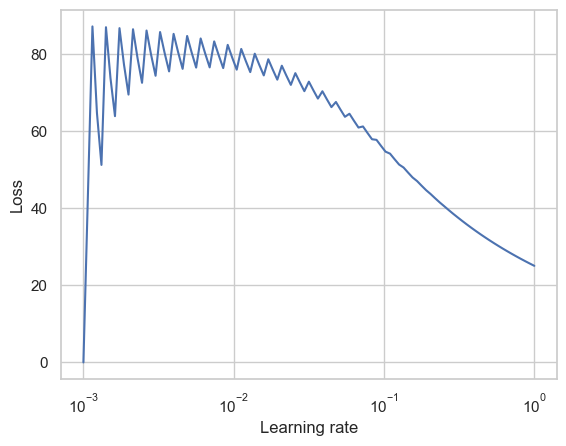

In [103]:
fig = lr_find_results.plot()
fig.show();

In [104]:
model.learning_rate = new_lr
trainer.fit(model, train_dataloaders=dataloader)
print(model.final_bias.data)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


tensor(-15.9841)


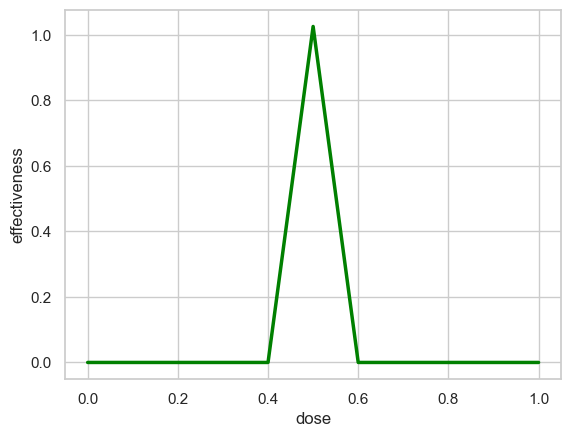

In [105]:
output_values = model(input_doses) 
sns.lineplot(
    x = input_doses, y = output_values.detach(), # as it has gradient so we strip the gradient 
    color = 'green', linewidth = 2.5
)
plt.ylabel('effectiveness')
plt.xlabel('dose');